# Benchmarking the performance of ChromaDB query

Dataset: OpenLibrary dump filtered for title + description available  
Number of embeddings: 1 342 792  
Embeding function : default (Sentence Transformers all-MiniLM-L6-v2)
Distance function: defqult (L2)

In [62]:
from time import perf_counter
from statistics import mean, stdev
import gc

from psutil import Process
import chromadb
from matplotlib import pyplot as plt

In [14]:
db = chromadb.PersistentClient(path="books.chromadb")
col = db.get_collection(name="books")

# I - Impact of the number of results on the query time

The text queries are transformed into embeddings before the test starts.
Otherwise the first transformation wpuld tqke more time qnd would create outliers. 

The queries are done with `include=[]` to reduce the impact of serialization 
on the results.

In [16]:
"""Initialize inputs"""

queries_txt = [
    "Foundations Asimov",
    "Space opera sci-fi",
    "Fantaisy books like Discworld by Terry Pratchett",
    "The Donut Theory",
    "The dictator's handbook"
    "The Name of the Wind by Patrick Rothfuss",
]

queries = [
    col.query(query_texts=txt, n_results=1, include=["embeddings"])["embeddings"][0]
for txt in queries_txt]


limits = [
    1, 10, 100, 1_000, 10_000, 100_000
]

results = { limit : [] for limit in limits}

In [19]:
""" Run the benchmark"""

for limit in limits:
    print("Limit: ", limit)
    for query in queries:
        for _ in range(100):
            t0 = perf_counter()
            col.query(
                query_embeddings=query,
                n_results=limit,
                include=[],
            )
            results[limit].append(perf_counter() - t0)



Limit:  1
Limit:  10
Limit:  100
Limit:  1000
Limit:  10000
Limit:  100000


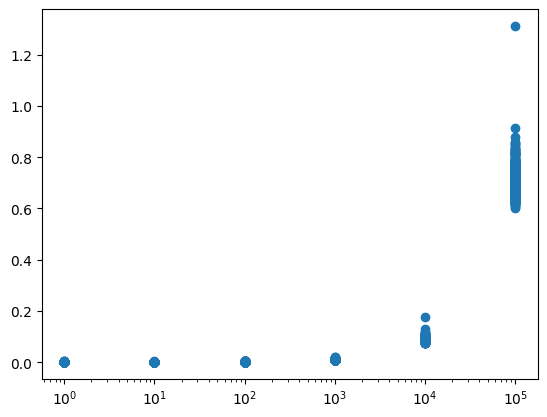

In [20]:
xs = []
ys = []
for x in limits:
    for y in results[x]:
        xs.append(x)
        ys.append(y)

plt.xscale('log')
plt.scatter(xs, ys)

Text(0.5, 0, 'n_results')

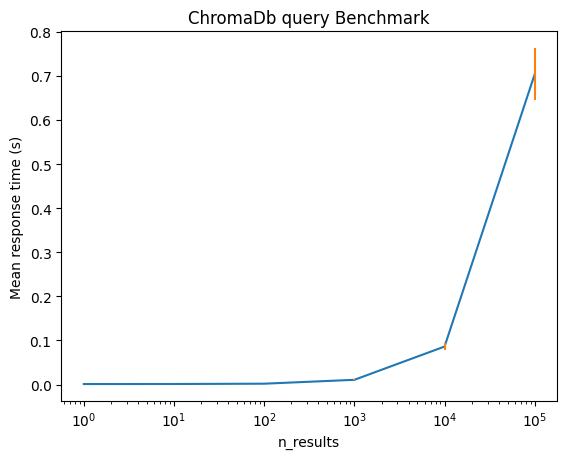

In [40]:
means = [ mean(results[limit]) for limit in limits]
stdevs =  [ stdev(results[limit]) for limit in limits]

plt.plot(limits, means)
plt.errorbar(limits, means, stdevs, linestyle='None',)
plt.xscale('log')
plt.title("ChromaDb query Benchmark")
plt.ylabel("Mean response time (s)")
plt.xlabel("n_results")


In [44]:
# TODO: Print results as markdown table

# II - Memory usage of N embeddings when extracted from the database

Warning: Memory usage is measured with `psutil.virtual_memory().used`, it mean 
we can only measure RAM allocation, not swap. Also ze must make sure to clean 
allocations between each test.

In [68]:
limits = [
    1, 10, 100, 1_000, 10_000, 100_000, 1_000_000
]


In [69]:
results = []
embeddings = []
for limit in limits:
    del embeddings
    gc.collect()
    
    m0 =  Process().memory_info().rss
    embeddings = col.get(limit=limit, include=["embeddings"])
    m1 = Process().memory_info().rss - m0
    results.append(m1)

In [70]:
for r in results:
    print(r / 1_000_000, "MB")


-0.262144 MB
0.0 MB
0.0 MB
2.78528 MB
135.49568 MB
1655.795712 MB
20180.209664 MB


Text(0.5, 0, 'number of embeddings')

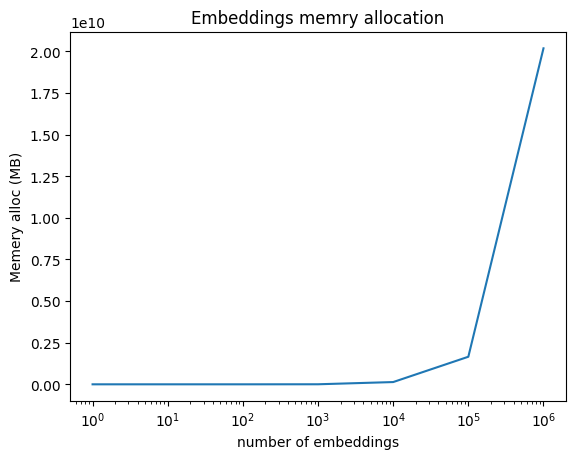

In [71]:
plt.plot(limits, results / 1_000_000)
plt.xscale('log')
plt.title("Embeddings memory allocation")
plt.ylabel("Memery alloc (MB)")
plt.xlabel("number of embeddings")